# TODO
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide,
    overlay_one_image_on_another
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
# reload configs
from configs.v009_cats import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])

In [4]:
truly_load_data = False
to_delete = True

# 0. Create dataframe of settings

In [5]:
# Create settings df
data_settings = fill_default_settings(data_settings)

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)


# Create folders for audio tts
tts_zh_path = f"output/tts/{data_settings['voice_name_zh']}"
tts_en_path = f"output/tts/{data_settings['voice_name_en']}"
if not os.path.exists(tts_zh_path):
    os.mkdir(tts_zh_path)
if not os.path.exists(tts_en_path):
    os.mkdir(tts_en_path)
data_settings

{'recording_id': 'ec_csent',
 'filename_suffix': 'cat_new_voice',
 'categories2_allowed': ['cat'],
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'sort_keys': ['priority', 'pinyin'],
 'sort_asc': [True, True],
 'voice_name_zh': 'zh-CN-XiaomoNeural',
 'voice_name_en': 'en-US-AriaNeural',
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'min_combo_quality': 6,
 'categories_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_str': '',
 'min_adu': 1,
 'min_per': 1,
 'min_date': '2025-01-01',
 'contains_character': None,
 'exclude_words': None,
 'max_count': 1000000,
 'recording_name': '0930_ec_csent_cat_new_voice'}

# 1. Load data

In [ ]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('static/latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('static/latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
if len(df_dups) > 0:
    df_dups.head(20)
else:
    df_all_vocab.head(3)

!!!!!!!! WARNING: not truly loading data !!!!!!!!
# duplicate vocab: 2
(5480, 28)


# 2. Select data

In [7]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

0930_ec_csent_cat_new_voice 34


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,5470,猫,māo,cat,single char,1.0,5.0,5.0,5.0,NaN,animal,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,2025-09-29,daily add,5.0,5.0
1,5517,打哈欠,dǎ hā qian,to yawn,combo,2.0,5.0,5.0,5.0,NaN,general,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,2025-09-29,daily add,5.0,5.0
2,5490,兽医,shòu yī,veterinarian,combo,2.0,5.0,5.0,5.0,NaN,general,cat,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",2025-09-29,daily add,5.0,5.0


# 3. Create vocabulary audio recordings

In [8]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, data_settings)

0.0s, row0
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 猫
0.000s, ALREADY EXISTS, en-US-AriaNeural, cat
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 我家有一只可爱的猫。
0.0s, row1
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 打哈欠
0.000s, ALREADY EXISTS, en-US-AriaNeural, to yawn
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 小猫不停打哈欠。
0.0s, row2
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 兽医
0.000s, ALREADY EXISTS, en-US-AriaNeural, veterinarian
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 猫生病了要带去看兽医。
0.0s, row3
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 尾巴
0.000s, ALREADY EXISTS, en-US-AriaNeural, tail
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 猫的尾巴很长。
0.0s, row4
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 项圈
0.000s, ALREADY EXISTS, en-US-AriaNeural, collar
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 我给猫买了一个新项圈。
0.0s, row5
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 打疫苗
0.000s, ALREADY EXISTS, en-US-AriaNeural, to get vaccinated
0.000s, ALREADY EXISTS, zh-CN-XiaomoNeural, 小猫需要打疫苗。
0.0s, row6
0.000s, 

## 3b. Compute durations of combined audios for each vocab word

In [9]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {data_settings['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, data_settings)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.32 seconds, recid0930_ec_csent_cat_new_voice, row 0, 猫
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 1, 打哈欠
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 2, 兽医
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 3, 尾巴
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 4, 项圈
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 5, 打疫苗
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 6, 翻肚皮
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 7, 高冷
0.30 seconds, recid0930_ec_csent_cat_new_voice, row 8, 胡须
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 9, 呼噜
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 10, 绝育
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 11, 流浪猫
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 12, 喵喵
0.28 seconds, recid0930_ec_csent_cat_new_voice, row 13, 猫咖
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 14, 猫粮
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 15, 猫零食
0.29 seconds, recid0930_ec_csent_cat_new_voice, row 16, 猫咪
0.2

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,1.464,0.864,2.064,0,1.964,3.328,6.392,6.391667,None,None,None
1,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,1.656,1.200,2.016,0,2.156,3.856,6.872,6.871667,None,None,None
2,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.920,1.128,2.616,0,2.420,4.048,7.664,7.663667,None,None,None


# 4. Create non-vocab audio recordings

In [10]:
from utils_audio import generate_nonvocab_audio_and_compute_durations

In [11]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head(10)

intro audio already generated: 欢迎观看我的普通话数据库视频 9: 猫词汇及例句
word_list audio already generated: 这些是将在接下来的4分钟内复习的34个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 9: 猫词汇及例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.520000,output/videos/0930_ec_csent_cat_new_voice/欢迎观看...,500,intro,5.520000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的4分钟内复习的34个单词,Zhèxiē shì jiàng zài jiē xiàlái de 4 fēnzhōng ...,These are the 34 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000,output/videos/0930_ec_csent_cat_new_voice/这些是将...,500,word_list,10.510000,5.520000,NaN,NaN,NaN
2,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,1.464,0.864,2.064,0.0,1.964,3.328,6.392,6.391667,None,None,None,16.901667,10.510000,10.510000,12.474000,13.838000
3,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,1.656,1.200,2.016,0.0,2.156,3.856,6.872,6.871667,None,None,None,23.773333,16.901667,16.901667,19.057667,20.757667
4,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.920,1.128,2.616,0.0,2.420,4.048,7.664,7.663667,None,None,None,31.437000,23.773333,23.773333,26.193333,27.821333
5,尾巴,wěi ba,tail,猫的尾巴很长。,māo de wěi ba hěn cháng.,The cat’s tail is very long.,1.536,1.056,1.728,0.0,2.036,3.592,6.320,6.319667,None,None,None,37.756667,31.437000,31.437000,33.473000,35.029000
6,项圈,xiàng quān,collar,我给猫买了一个新项圈。,wǒ gěi māo mǎi le yī gè xīn xiàng quān.,I bought a new collar for the cat.,1.488,1.152,2.208,0.0,1.988,3.640,6.848,6.847667,None,None,None,44.604333,37.756667,37.756667,39.744667,41.396667
7,打疫苗,dǎ yì miáo,to get vaccinated,小猫需要打疫苗。,xiǎo māo xū yào dǎ yì miáo.,Kittens need vaccinations.,2.136,1.224,1.944,0.0,2.636,4.360,7.304,7.303667,None,None,None,51.908000,44.604333,44.604333,47.240333,48.964333
8,翻肚皮,fān dù pí,to roll over (show belly),猫翻肚皮要你摸。,māo fān dù pí yào nǐ mō.,The cat rolls over to ask for belly rubs.,2.616,1.344,1.896,0.0,3.116,4.960,7.856,7.855667,None,None,None,59.763667,51.908000,51.908000,55.024000,56.868000
9,高冷,gāo lěng,aloof,猫看起来很高冷。,māo kàn qǐ lái hěn gāo lěng.,Cats often look aloof.,1.584,1.104,1.920,0.0,2.084,3.688,6.608,6.607667,None,None,None,66.371333,59.763667,59.763667,61.847667,63.451667


# 5. Combine individual vocab into final audio recording

In [12]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

3.42s, output/videos/0930_ec_csent_cat_new_voice/audio.mp3


# 6. Create images for video

In [13]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{data_settings['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {data_settings['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

0930_ec_csent_cat_new_voice loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,d_english,d_chinese,d_sent,rel_start_english,rel_start_chinese,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_english,start_chinese,start_sent
0,欢迎观看我的普通话数据库视频 9: 猫词汇及例句,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.520000,output/videos/0930_ec_csent_cat_new_voice/欢迎观看...,500.0,intro,5.520000,0.000000,NaN,NaN,NaN
1,这些是将在接下来的4分钟内复习的34个单词,Zhèxiē shì jiàng zài jiē xiàlái de 4 fēnzhōng ...,These are the 34 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.990000,output/videos/0930_ec_csent_cat_new_voice/这些是将...,500.0,word_list,10.510000,5.520000,NaN,NaN,NaN
2,猫,māo,cat,我家有一只可爱的猫。,wǒ jiā yǒu yī zhī kě ài de māo.,I have a cute cat at home.,1.464,0.864,2.064,0.0,1.964,3.328,6.392,6.391667,NaN,NaN,NaN,16.901667,10.510000,10.510000,12.474000,13.838000
3,打哈欠,dǎ hā qian,to yawn,小猫不停打哈欠。,xiǎo māo bù tíng dǎ hā qian.,The kitten keeps yawning.,1.656,1.200,2.016,0.0,2.156,3.856,6.872,6.871667,NaN,NaN,NaN,23.773333,16.901667,16.901667,19.057667,20.757667
4,兽医,shòu yī,veterinarian,猫生病了要带去看兽医。,māo shēng bìng le yào dài qù kàn shòu yī.,"If the cat is sick, take it to the vet.",1.920,1.128,2.616,0.0,2.420,4.048,7.664,7.663667,NaN,NaN,NaN,31.437000,23.773333,23.773333,26.193333,27.821333


In [14]:
# # Convert dataframe into list of what is said
# to_say_dict = {'text': [], 'row_index': [], 'row_col': []}
# for i_row, row in df_vocab_audio_durations.iterrows():
#     if pd.isna(row['sum_theory']):
#         to_say_dict['text'].append(row['chinese'])
#         to_say_dict['row_col'].append('chinese')
#         to_say_dict['row_index'].append(i_row)
#     else:
#         if data_settings['recording_id'] in ['ec_csent']:
#             to_say_dict['text'].append(row['english'])
#             to_say_dict['row_col'].append('english')
#             to_say_dict['row_index'].append(i_row)

#             to_say_dict['text'].append(row['chinese'])
#             to_say_dict['row_col'].append('chinese')
#             to_say_dict['row_index'].append(i_row)

#             to_say_dict['text'].append(row['sentence'])
#             to_say_dict['row_col'].append('sentence')
#             to_say_dict['row_index'].append(i_row)
#         else:
#             raise ValueError(f"Unknown recording id: {data_settings['recording_id']}")
#     if i_row >= 5:
#         break

# # Output the list of text as a txt file
# with open(f'{project_artifacts_folder}/lines_to_read.txt', 'w') as f:
#     for line in to_say_dict['text']:
#         f.write(f"{line}\n")

# to_say_df = pd.DataFrame(to_say_dict)
# to_say_df.head(10)

## 6a. Vocab words

Drawing 0: 猫
Drawing 1: 打哈欠
Drawing 2: 兽医
Drawing 3: 尾巴
Drawing 4: 项圈
Drawing 5: 打疫苗
Drawing 6: 翻肚皮
Drawing 7: 高冷
Drawing 8: 胡须
Drawing 9: 呼噜
Drawing 10: 绝育
Drawing 11: 流浪猫
Drawing 12: 喵喵
Drawing 13: 猫咖
Drawing 14: 猫粮
Drawing 15: 猫零食
Drawing 16: 猫咪
Drawing 17: 猫砂
Drawing 18: 粘人
Drawing 19: 小猫
Drawing 20: 爪子
Drawing 21: 蹭腿
Drawing 22: 掉毛
Drawing 23: 逗猫棒
Drawing 24: 罐头
Drawing 25: 猫薄荷
Drawing 26: 猫叫
Drawing 27: 猫毛
Drawing 28: 猫砂盆
Drawing 29: 猫塔
Drawing 30: 猫抓板
Drawing 31: 蜷着
Drawing 32: 梳毛
Drawing 33: 舔毛



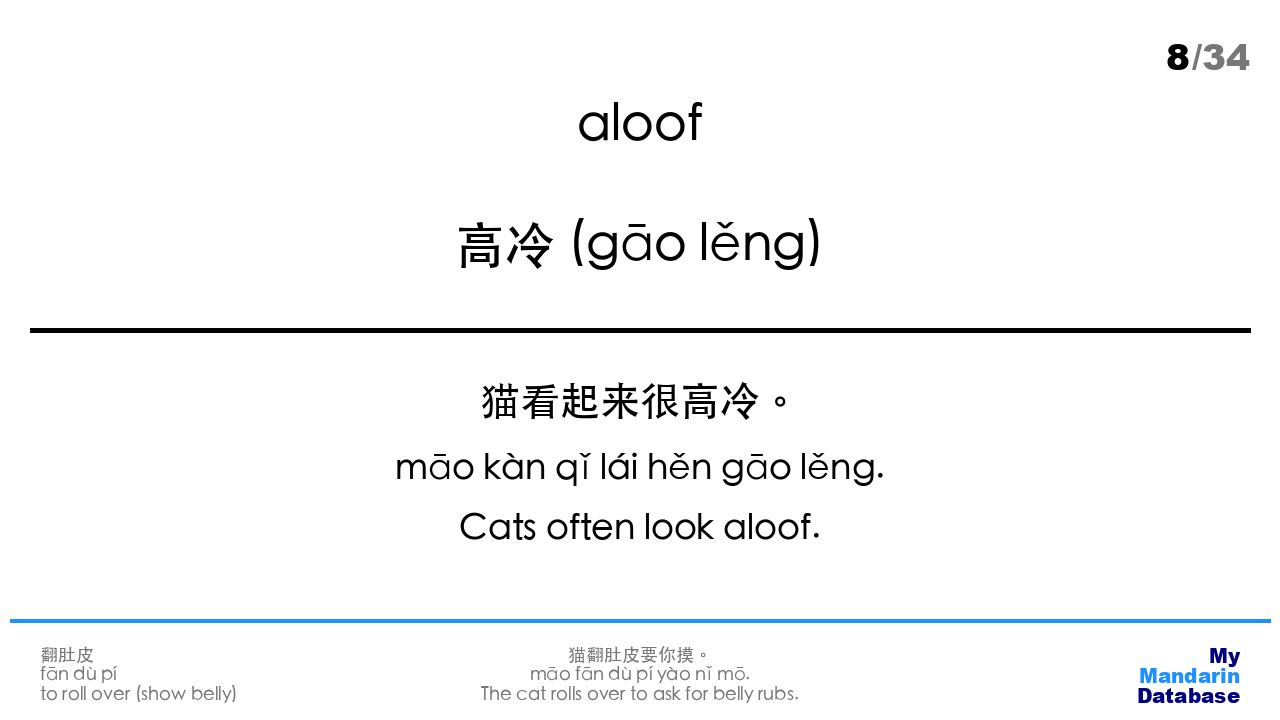

In [15]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent', 'ec_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[23].display_in_notebook()

# 7. Create non-vocab slides


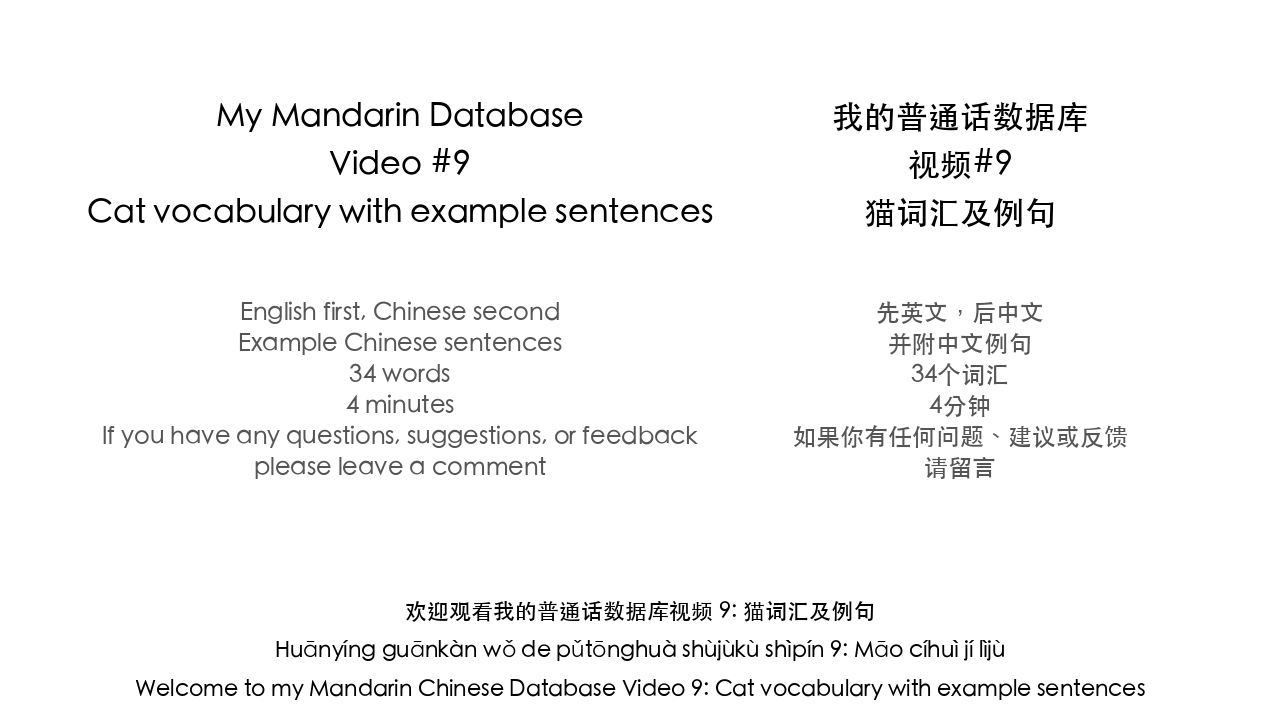

In [16]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()


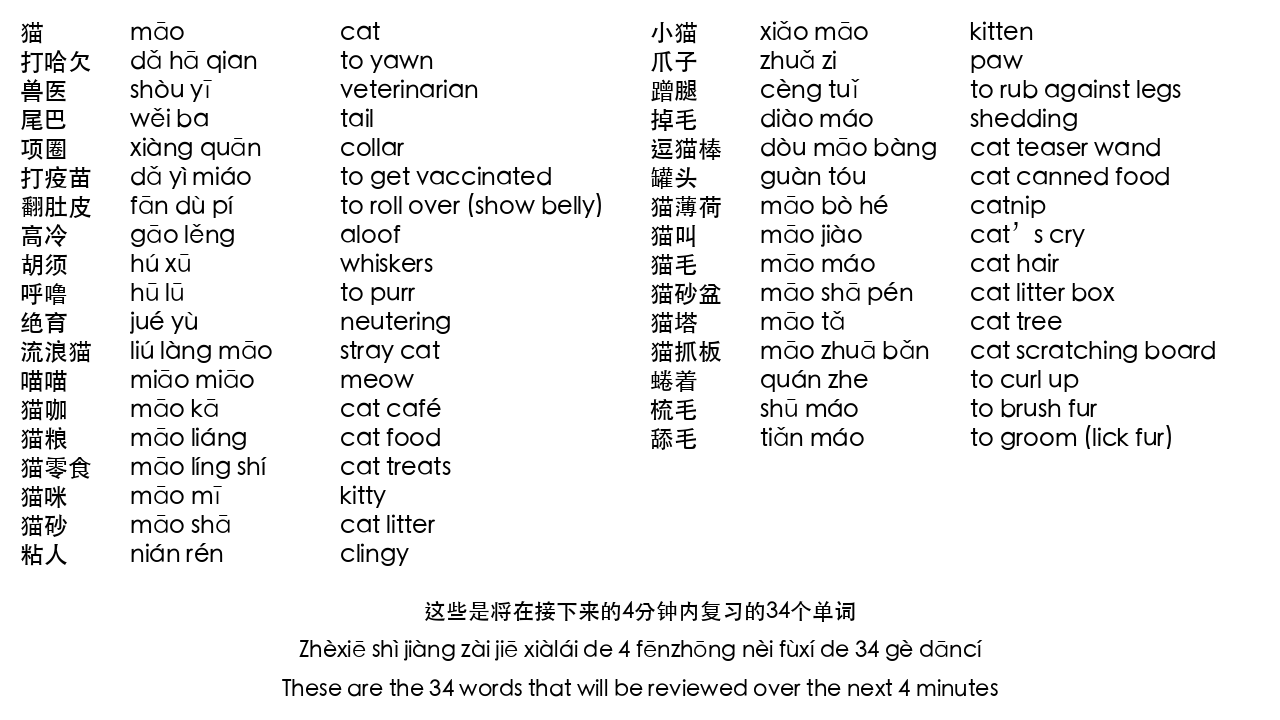

In [17]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()


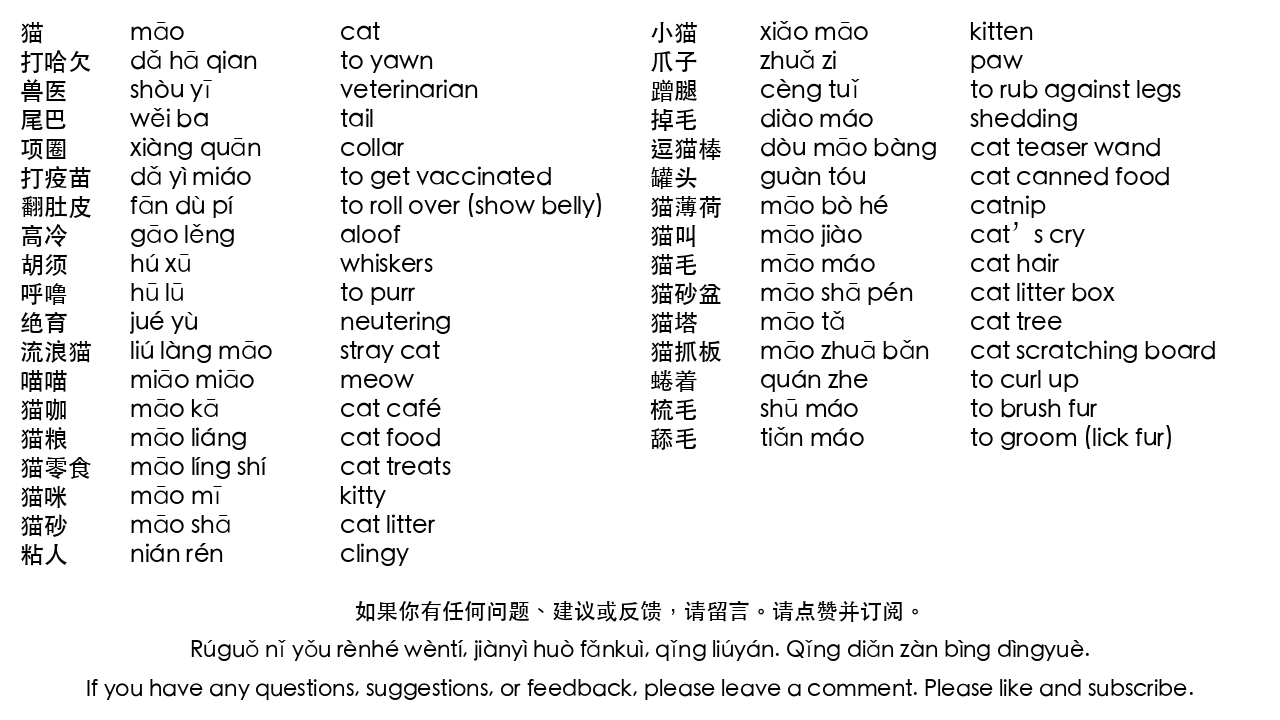

In [18]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


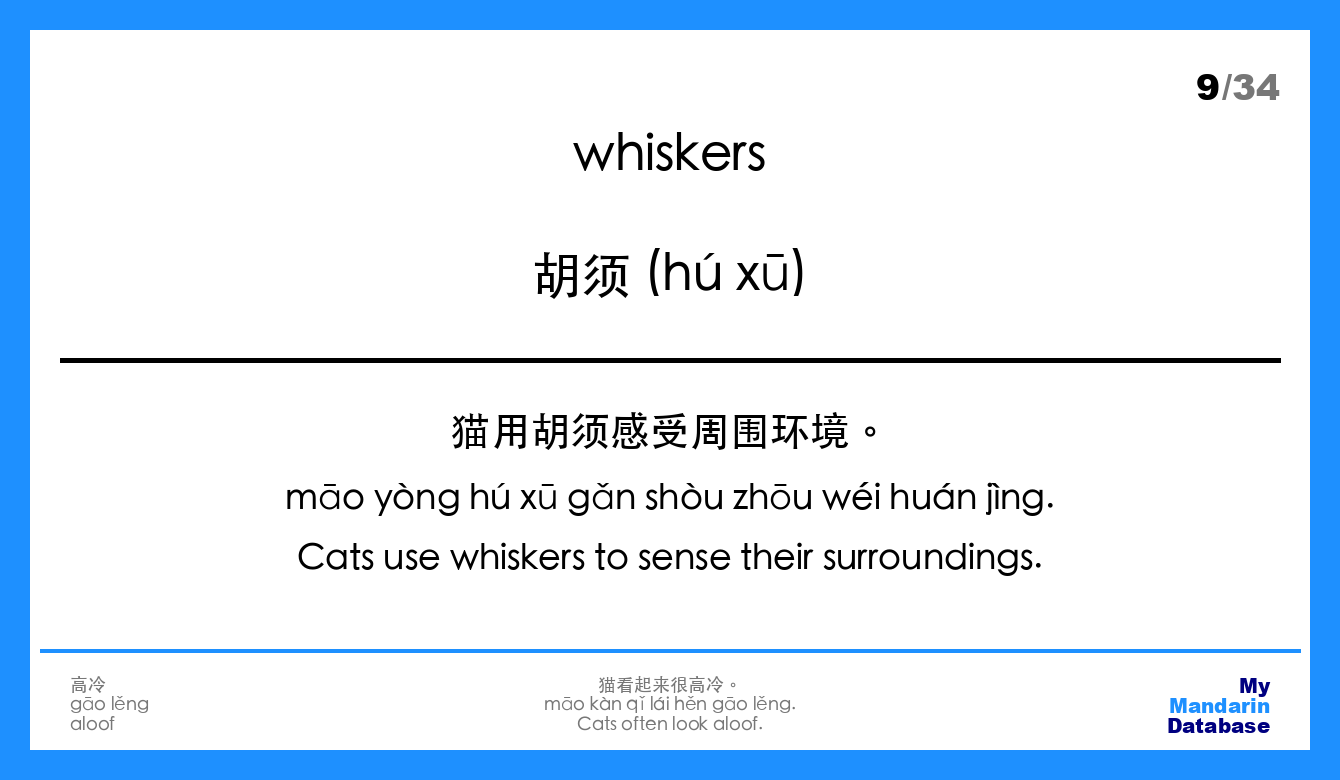

In [19]:
# icon_configs['word'] = '胡须'
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [20]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 105
audio: 254.830s, video: 254.775s; difference: 0.055s
MoviePy - Building video output/videos/0930_ec_csent_cat_new_voice/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos/0930_ec_csent_cat_new_voice/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos/0930_ec_csent_cat_new_voice/video.mp4


# 10. Overlay another image on original icon

In [50]:
overlay_image = False
if overlay_image:
    original_icon_path = f'{project_artifacts_folder}/icon.png'
    mario_slide_path = f'{project_artifacts_folder}/chinese_cat.png'
    new_image_path = f'{project_artifacts_folder}/icon_with_pic.png'
    xy_offset = (-500, 0)
    new_img = overlay_one_image_on_another(original_icon_path, mario_slide_path, xy_offset, new_image_path)
    new_img.display_in_notebook()

# 11. compare tts

In [51]:
from utils_audio import generate_example_recordings_from_all_edge_tts_voices
generate_example_recordings_from_all_edge_tts_voices(
    '靠近点，我想闻你身上的味道', 'zh', filter_gender=['Female'], filter_personality='Confident')
generate_example_recordings_from_all_edge_tts_voices(
    "Come closer, I want your scent", 'en', filter_gender=['Female'], filter_personality='Confident')

0.000s, zh-CN-XiaoruiNeural
0.000s, zh-CN-XiaoyuMultilingualNeural
0.000s, zh-CN-XiaozhenNeural
0.000s, zh-CN-shaanxi-XiaoniNeural
0.000s, en-US-MichelleNeural
0.000s, en-US-NancyNeural
0.000s, en-US-SaraNeural
